# **Predicting Wine Quality Through Classification and Regression**
#### DSCI 100 Winter T2 Group 006-042

## Introduction:

[insert introduction here]

## Preliminary Exploratory Data Analysis:

In [2]:
# loading libraries
library(tidyverse)
library(tidymodels)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### Attribute (units):
- Fixed acidity ($g/dm^3$)
- Volatile acidity ($g/dm^3$)
- Citric acid ($g/dm^3$)
- Residual sugar ($g/dm^3$)
- Chlorides ($g/dm^3$)
- Free sulfur dioxide ($mg/dm^3$)
- Total sulfur dioxide ($mg/dm^3$)
- Density ($g/cm^3$)
- pH
- Sulphates ($g/dm^3$)
- Alcohol ($vol.\%$)

In [4]:
# reading data
data <- read_csv("data/wine_quality.csv") %>%
        subset(select = -Id)

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double(),
  Id = col_double()
)



In [5]:
# cleaning and wrangling data
colnames(data) <- gsub(" ", "_", names(data))
colnames(data)[colnames(data) %in% c("free_sulfur_dioxide", "total_sulfur_dioxide")] <- c("free_so2", "total_so2")

clean_data <- data %>%
              mutate(quality = quality - 2) %>%
              mutate(quality = as_factor(quality)) %>%
              subset(select = -c(fixed_acidity, volatile_acidity, citric_acid, free_so2))

In [6]:
# splitting data
clean_data_split <- initial_split(clean_data, prop = 0.5, strata = quality)
train_data <- training(clean_data_split)
test_data <- testing(clean_data_split)

In [7]:
glimpse(train_data)

Rows: 572
Columns: 8
$ residual_sugar <dbl> 2.3, 1.9, 1.9, 2.0, 1.6, 1.8, 2.3, 1.6, 1.4, 2.3, 5.5,…
$ chlorides      <dbl> 0.092, 0.075, 0.076, 0.073, 0.114, 0.092, 0.082, 0.106…
$ total_so2      <dbl> 54, 60, 34, 18, 29, 103, 71, 37, 23, 113, 18, 15, 30, …
$ density        <dbl> 0.9970, 0.9980, 0.9978, 0.9968, 0.9974, 0.9969, 0.9982…
$ pH             <dbl> 3.26, 3.16, 3.51, 3.36, 3.26, 3.30, 3.52, 3.17, 3.34, …
$ sulphates      <dbl> 0.65, 0.58, 0.56, 0.57, 1.56, 0.75, 0.65, 0.91, 0.56, …
$ alcohol        <dbl> 9.8, 9.8, 9.4, 9.5, 9.1, 10.5, 9.7, 9.5, 9.3, 9.8, 9.6…
$ quality        <fct> 3, 4, 3, 5, 3, 5, 3, 3, 3, 3, 4, 4, 5, 3, 4, 2, 3, 3, …


In [8]:
# summarizing data
train_data_mean_summary <- train_data %>%
                           select(-quality) %>%
                           map_dfr(mean, na.rm = TRUE)
colnames(train_data_mean_summary) <- paste("mean", colnames(train_data_mean_summary), sep = "_")

train_data_quality_summary <- train_data %>%
                              group_by(quality) %>%
                              summarize(count = n(),
                                        proportion = n() / nrow(train_data) * 100)

`summarise()` ungrouping output (override with `.groups` argument)



In [9]:
# mean of predictor variables
train_data_mean_summary

mean_residual_sugar,mean_chlorides,mean_total_so2,mean_density,mean_pH,mean_sulphates,mean_alcohol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.535052,0.08839685,46.55157,0.9967492,3.309773,0.6658916,10.42392


In [10]:
# number of observations for each class
train_data_quality_summary

quality,count,proportion
<fct>,<int>,<dbl>
1,2,0.3496503
2,16,2.7972028
3,242,42.3076923
4,230,40.2097902
5,74,12.9370629
6,8,1.3986014


In [38]:
# scaling data
train_data_scaled <- train_data %>%
                     mutate_at(vars(-quality),
                               ~(scale(., center = TRUE) %>% as.vector))
train_data_scaled

residual_sugar,chlorides,total_so2,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.17058318,0.06865702,0.22116634,0.13069071,-0.313948394,-0.09273024,-0.57407060,3
-0.46087274,-0.25527353,0.39932452,0.65181364,-0.944712291,-0.50119215,-0.57407060,4
-0.46087274,-0.23621879,-0.37269423,0.54758905,1.262961347,-0.61789556,-0.94211064,3
-0.38830035,-0.29338301,-0.84778269,0.02646612,0.316815503,-0.55954385,-0.85010063,5
-0.67858991,0.48786127,-0.52115937,0.33913988,-0.313948394,5.21727462,-1.21814067,3
-0.53344513,0.06865702,1.67612475,0.07857841,-0.061642835,0.49078678,0.06999946,5
-0.17058318,-0.12189036,0.72594783,0.75603822,1.326037737,-0.09273024,-0.66608061,3
-0.67858991,0.33542336,-0.28361514,-0.07775847,-0.881635901,1.42441401,-0.85010063,3
-0.82373469,-0.15999984,-0.69931755,-0.65099369,0.190662723,-0.61789556,-1.03412065,3


quality,residual_sugar,chlorides,total_so2,density,pH,sulphates,alcohol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,-0.17058318,0.06865702,0.22116634,0.13069071,-0.313948394,-0.09273024,-0.57407060
4,-0.46087274,-0.25527353,0.39932452,0.65181364,-0.944712291,-0.50119215,-0.57407060
3,-0.46087274,-0.23621879,-0.37269423,0.54758905,1.262961347,-0.61789556,-0.94211064
5,-0.38830035,-0.29338301,-0.84778269,0.02646612,0.316815503,-0.55954385,-0.85010063
3,-0.67858991,0.48786127,-0.52115937,0.33913988,-0.313948394,5.21727462,-1.21814067
5,-0.53344513,0.06865702,1.67612475,0.07857841,-0.061642835,0.49078678,0.06999946
3,-0.17058318,-0.12189036,0.72594783,0.75603822,1.326037737,-0.09273024,-0.66608061
3,-0.67858991,0.33542336,-0.28361514,-0.07775847,-0.881635901,1.42441401,-0.85010063
3,-0.82373469,-0.15999984,-0.69931755,-0.65099369,0.190662723,-0.61789556,-1.03412065


[1] "quality ~ residual_sugar+chlorides+total_so2+density+pH+sulphates+alcohol"

! Fold1: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '1'
Com...

! Fold4: internal: No observations were detected in `t

size,model_string,accuracy
<int>,<chr>,<dbl>
1,quality ~ alcohol,0.5384150
2,quality ~ alcohol+pH,0.5822444
3,quality ~ alcohol+pH+sulphates,0.5924380
4,quality ~ alcohol+pH+sulphates+total_so2,0.5998488
5,quality ~ alcohol+pH+sulphates+total_so2+residual_sugar,0.6015124
6,quality ~ alcohol+pH+sulphates+total_so2+residual_sugar+chlorides,0.5997278
7,quality ~ alcohol+pH+sulphates+total_so2+residual_sugar+chlorides+density,0.5838173


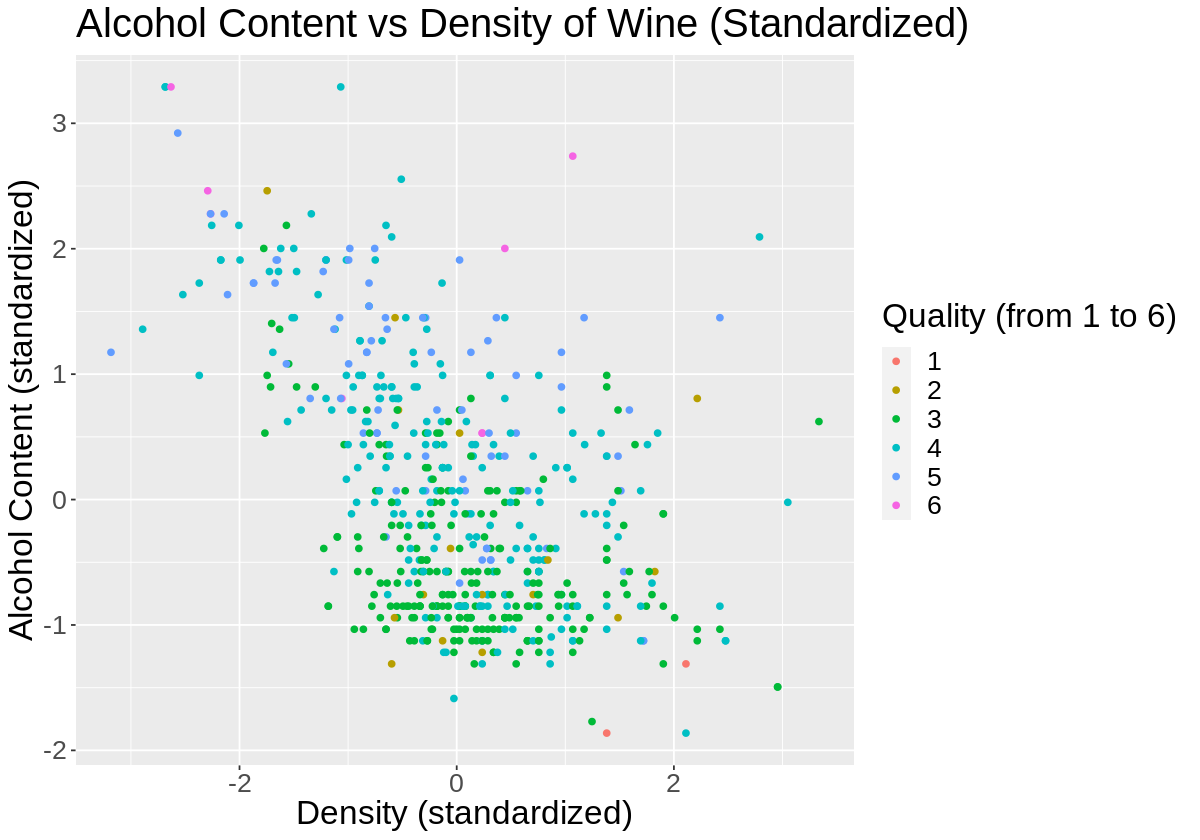

In [48]:
# visualizing data
options(repr.plot.width = 10, options.repr.plot.height = 15)

train_plot <- train_data_scaled %>%
                ggplot(aes(x = density , y = alcohol , color = quality)) +
                geom_point() +
                labs(x = "Density (standardized)" , y = "Alcohol Content (standardized)" , color = "Quality (from 1 to 6)") + 
                ggtitle("Alcohol Content vs Density of Wine (Standardized)") +
                theme(text = element_text(size = 20))
train_plot

data_subset <- train_data_scaled %>%
  select(quality, residual_sugar, chlorides, total_so2, density, pH, sulphates, alcohol)

names <- colnames(data_subset %>% select(-quality))

data_subset

example_formula <- paste("quality", "~", paste(names, collapse="+"))
example_formula

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
data_vfold <- vfold_cv(data_subset, v = 5, strata = quality)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("quality", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        data_recipe <- recipe(as.formula(model_string), 
                                data = data_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(data_recipe) %>%
          add_model(spec) %>%
          tune_grid(resamples = data_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

## Methods:

[insert methods here]

## Expected Outcomes and Significance:

[insert expected outcomes and significance here]